<font size=7>Eigenvectors

In this notebook will see how eigenvectors and eigenvalues are useful for data analysis. This notebook goes into more detail on an idea alluded to in section 5.13 of the class textbook, "Representing correlated inputs". A set of neurons could learn a transformation $M$ such that the internal representation $M \mathbf{x}$ is more useful than the raw input vector $\mathbf x$. We will explore what such a transformation $M$ could look like, and discuss what statistical properties of the input it is able to pick up.

Imagine an organism that lives in a flat world and perceives everything in a one-dimensional visual field. We will assume that its eyes work like a camera (i.e. not like a realistic retina), measuring light intensity at $K$ identical pixels arranged in a straight line. We will use this organism as a thought experiment to explore the statistics of input data with structure in one dimension.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

<font color="red">
    
**To Do:**
* Put a better description of the red text in the "non-noise" section, <b>1.3</b>
* Change lower-case $k$ to another variable. It's confusing when already have upper-case $K$

# Correlation and Geometric Similarity

## Correlation Matrices

If we record what our flat organism sees at $N$ different times, we will have $N$ different samples of $K$-dimensional observations.
We can collect these observations in a $K \times N$ matrix $X$ and analyze it using correlations.

We can view $X$ as a set of $N$ different $k$-variable observation vectors and take the expectation of the products of pairs of variables from these $k$ over all observations $n \in [1 \ldots N]$. This gives a normalized inner product for each pair of rows of $X$. This results in a $K \times K$ correlation matrix that represents the statistical relationships between these variables.

Alternately, we can choose to see our data as $N$ points in a $K$-dimensional space and take inner products between pairs of points. Here an inner product can be viewed as the expectation of the products of pairs of coordinate values over $k \in [1 \ldots K]$. This is an inner products of a pair of columns of $X$. This results in the $N \times N$ geometric similarity matrix, which represents geometric relationships among the points.

The geometric similarity can be useful—for example, it will have local structure if our visual observations are related to each other through time. However, the correlation matrix is more fundamental. If we get more observations of the same variables, $N$ increases but $K$ stays the same, meaning that the geometric similarity matrix grows in size and becomes unwieldy, whereas the correlation matrix just has more data available to make each individual entry more precise.

## Noise Correlations

Imagine now that the organism's eye is bombarded with random photons that have no relationship to each other. This is a completely noisy data source, where each of the data variables has mean zero and variance 1, and they are all independent.

The correlation matrix representing the relationship between the $K$ different observation dimensions is plotted below for $N=1000$ and $K=128$. There are no particular relationships between the input variables, so there is no structure to the correlation matrix. It looks like a noisy approximation to the $K \times K$ identity matrix.

In the textbook, we discussed the covariance matrix of a sample which has been normalized by subtracting its observed mean and dividing by its observed standard deviation. This results in the simple expression $\tfrac1N X X^T$ for the correlation matrix.
However, in this notebook we are going to use the numpy function `corrcoef`, which computes this matrix by first normalizing the input data for us.

The input data we are using are drawn from the standard normal distribution using the `randn` function, which means that the underlying population mean and variance are 0 and 1 respectively, but individual samples may deviate from these expectations. This means that even though you can't see it here, you have to normalize the data _even if the population statistics are already correct_.

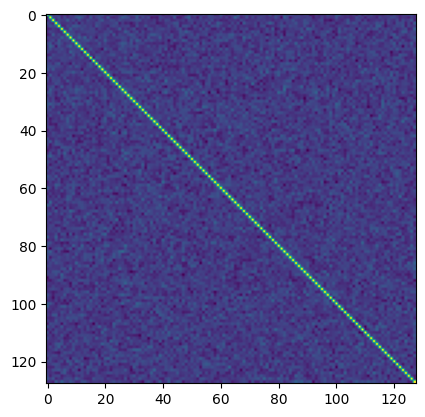

In [2]:
N, K = 250, 128
np.random.seed(0)
X_rand = np.random.randn(K, N)
C_rand = np.corrcoef(X_rand)
plt.imshow(C_rand);

## Non-noise Correlations

We have seen that if all the inputs to a system are independent white noise, the correlation matrix turns out to be pretty much just the identity matrix. That means there is no way to extract a transformation that helps express the data in a more useful way. Let's compare this situation to a matrix of input data which does actually include some meaningful correlation between the input variables.

We are still working with our imaginary organism that perceives a one-dimensional visual field, but this time, the data examples that it receives are all blob-shaped stimuli at various random locations within the visual field.

These stimuli have a total width of $k = 10\text{ pixels}$, (small $k=10$ is not the same as big $K=128$) and their overall shape is a Gaussian blob with the shape parameter $\sigma = 5$. It is not terribly important which form these blobs take, as it is their spatial locality that gives the correlation matrix shown below its structure. Because our inputs are spatially localized, if at any given time $t$ we know one component $\mathbf x_t[i]$ of the observation, then we also know that $\mathbf x_t[i+1]$ is likely to have a similar value.

In [3]:
N, K = 250, 128
k = 10
sigma = 5

# Create raw Gaussian blobs of the given sigma. The easiest
# way to do this in numpy/scipy is to use the normal distribution
# from scipy.stats. The "points" are the points on the retina, and
# the "centers" are the centers of the different observations in
# retina space.
np.random.seed(0)
points = np.arange(K)
centers = np.random.rand(N) * K
X_blob = scipy.stats.norm(
    scale=sigma, loc=centers
).pdf(points[:,np.newaxis])

# Mask the blobs off to k entries.
mask = np.abs(np.subtract.outer(points, centers)) < k
X_blob *= mask

<font color="red"> Plot of the matrix itself.

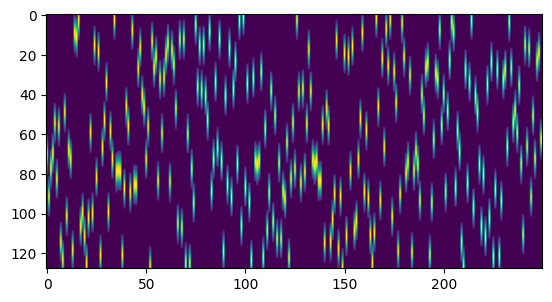

In [4]:
plt.imshow(X_blob);

<font color="red"> Plot of the correlation matrix for the rows of the previous plot above.

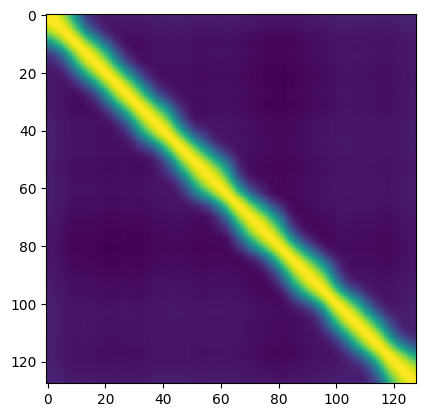

In [5]:
# Plot the correlation.
C_blob = np.corrcoef(X_blob)
plt.imshow(C_blob);

# Eigenvalues and Eigenvectors

The two correlation matrices we've seen before are definitely different, but both have an overall structure that looks pretty much like just a diagonal. We can find some really interesting differences between these cases though, especially by examining the eigenvalues and eigenvectors. The set of eigenvalues of a matrix is called its “spectrum”. We will investigate this first.

## Eigenvalue Spectrum

Recall from the textbook (section 5.9) that the eigenvectors of a linear transformation $M$ are those vectors $\mathbf x$ for which there exists a scalar $\lambda$ satisfying $M \mathbf x = \lambda \mathbf x$. The scalar $\lambda$ is the eigenvalue corresponding to the eigenvector $\mathbf x$.

Here since $M = \frac1N X X^T$ is symmetric, it is also a _normal_ matrix, meaning that it commutes with its transpose. These matrices have the special property that they are always diagonalized by a unitary transformation. This in turn means that there exists an orthonormal basis $U$ which, together with the diagonal matrix $\Lambda$ whose diagonal entries are the eigenvalues of $M$, can be used to express $M$ as $U \Lambda U^T$.

All correlation matrices are Hermitian (a matrix equal to it's own conjugate transpose), so to get $U$ and $\Lambda$, we don't use the general `eig` function. Hermitian matrices have real eigenvalues (and symmetric real matrices have real eigenvectors too), but `eig` returns complex numbers. Instead, we can use `eigh` to do the whole computation in real numbers, which is a more convenient output, and even makes it a bit faster and more numerically stable too. Note that the first output of this function is not actually $\Lambda$ but rather a vector `W` of the eigenvalues in ascending order; there is usually no reason to construct the entire matrix given that it is only diagonal. If you need $\Lambda$, you can create it with `np.diag(W)`.

In [6]:
def eigenvalues_eigenvectors(A):
    W, U = np.linalg.eigh(A)
    # The rank of A can be no greater than the smaller of its
    # dimensions, so cut off the returned values there.
    rank = min(*A.shape)
    U = U[:,-rank:]
    sgn = (-1)**(U[0,:] < 0)
    # Also reverse the order of the eigenvalues because eigh()
    # returns them in ascending order but descending makes more sense.
    return W[-rank:][::-1], (U*sgn[np.newaxis,:])[:, ::-1]

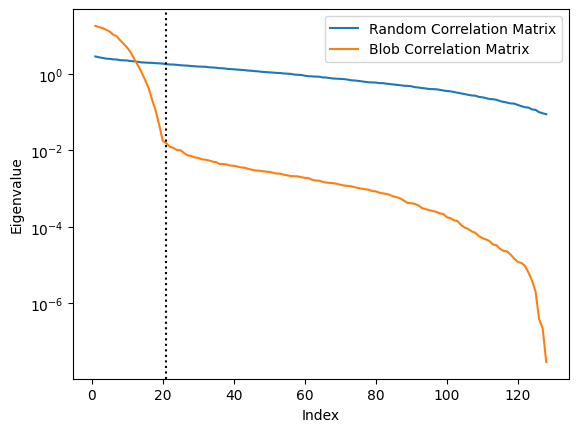

In [7]:
W_rand, U_rand = eigenvalues_eigenvectors(C_rand)  # noise correlation matrix from above
W_blob, U_blob = eigenvalues_eigenvectors(C_blob)  # non-noise correlation matrix from above 

index = 1 + np.arange(K)
plt.semilogy(index, W_rand, label='Random Correlation Matrix')
plt.plot(index, W_blob, label='Blob Correlation Matrix')
plt.xlabel('Index')
plt.ylabel('Eigenvalue')
plt.axvline(2*k+1, ls=':', c='k')
plt.legend();

In this case, there are just as many nonzero eigenvalues as $K$ because $K < N$. However, there is a clear “elbow” between two different groups of eigenvalues: the first $2k$ eigenvalues are clearly larger than the others. (Indicated with the dashed vertical line.) We'll manually truncate the eigenvector matrices $U$ to $2k$ “interesting” eigenvectors for the remaining analysis.

Finding the eigenvalues and vectors for the correlation matrix (technically speaking the covariance matrix), is the fundemental step of performing [Principal Components Analysis](https://en.wikipedia.org/wiki/Principal_component_analysis). Prinicipal components is an unsupervised methods for learning underlying structure in data. Even though the method is over 100 years old, it is still regularly used.

## Eigenvector Basis

We mentioned above that eigenvalues represent the importance of different components of the transformation represented by a matrix. The eigenvectors are those components! You can even use the eigenvectors together with the eigenvalues to create a low-rank approximation to a complete matrix via the Singular Value Decomposition (SVD).

Let's compare the eigenvectors between `C_rand` and `C_blob` in order to investigate how these matrices are built up from others. Below we plot the first **4** eigenvectors for both the noisy and non-noisy data. In this scenario the dimension of the eigenvector is $K=128$. Each x-coordinate corresponds to one of the dimensions of that eigenvector. Notice that the eigenvectors of the noisy data look like noise, where the non-noisy data has smooth eigenvectors. This is because the non-noisy data's eigenvectors represent structure in the data.

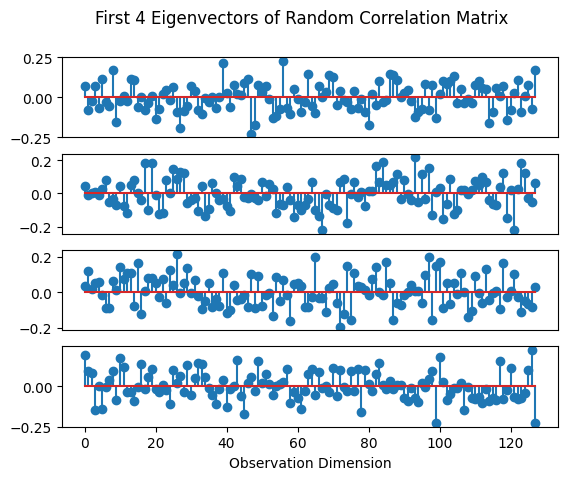

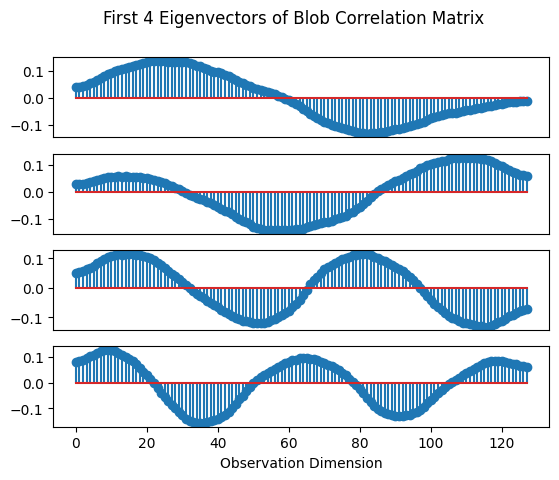

In [8]:
plt.figure()
for i in range(4):
    if i: plt.xticks([])
    plt.subplot(4, 1, i+1)
    plt.stem(U_rand[:,i])
plt.xlabel('Observation Dimension')
plt.suptitle('First 4 Eigenvectors of Random Correlation Matrix');

plt.figure()
for i in range(4):
    if i: plt.xticks([])
    plt.subplot(4, 1, i+1)
    plt.stem(U_blob[:,i])
plt.xlabel('Observation Dimension')
plt.suptitle('First 4 Eigenvectors of Blob Correlation Matrix');

Now lets plot all of the eigenvectors up to the cutoff at $2k=20$, that we observed in the eigenvalue spectrum of **section 2.1**. Rather than having 20 subplots, we plot each of the eigenvectors as a row of an image. We now you color, instead of a y-axis, to represent the numerical value of each coordinate in the eigenvector. Again, notice that the eigenvectors of the noisy data look like noise, where the non-noisy data has smooth pattern. We will explore this more deeply in the exercises.



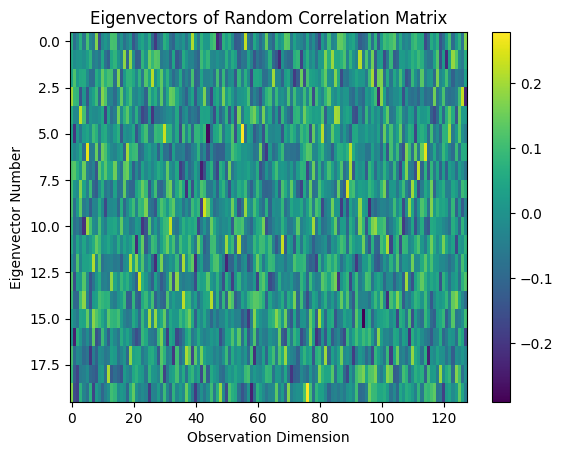

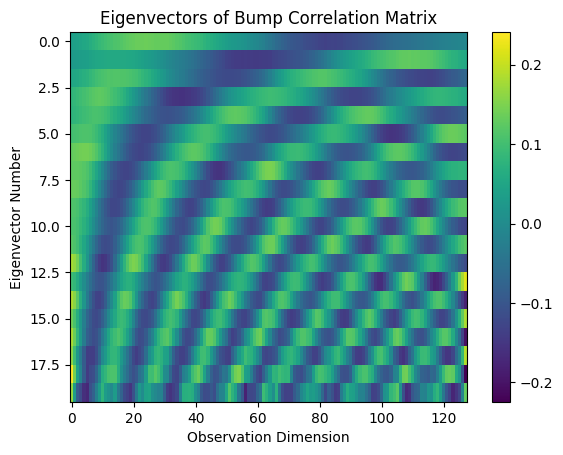

In [9]:
plt.figure(); plt.imshow(U_rand[:,:2*k].T, interpolation='none')
plt.gca().set_aspect('auto')
plt.ylabel('Eigenvector Number')
plt.xlabel('Observation Dimension')
plt.title('Eigenvectors of Random Correlation Matrix')
plt.colorbar()

plt.figure(); plt.imshow(U_blob[:,:2*k].T, interpolation='none')
plt.gca().set_aspect('auto')
plt.ylabel('Eigenvector Number')
plt.xlabel('Observation Dimension')
plt.title('Eigenvectors of Bump Correlation Matrix')
plt.colorbar();

# <font color="red"> Exercises

##  Noise Correlations <font color="red"> - 10 points

Consider the correlation matrix shown in **section 1.2**:

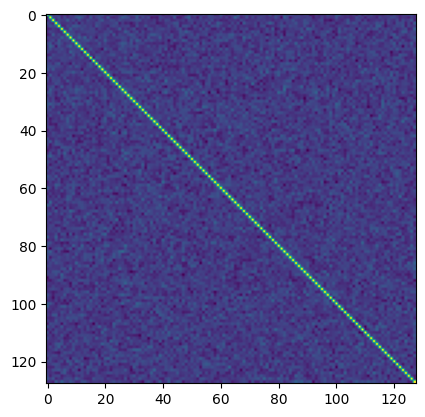

In [20]:
N, K = 250, 128
np.random.seed(0)
X_rand = np.random.randn(K, N)
C_rand = np.corrcoef(X_rand)
plt.imshow(C_rand);

### Changing $N$ <font color="red"> - 2 points

Try changing the value of $N$ in the cell that plots the correlation matrix. Try a few different orders of magnitude. How does the image change?

<font color="green"><b> Answer

<font color="red">
1 point - plots
    
1 point - explanation

<font color="green">Write code for creating plots with different values of $N$ below

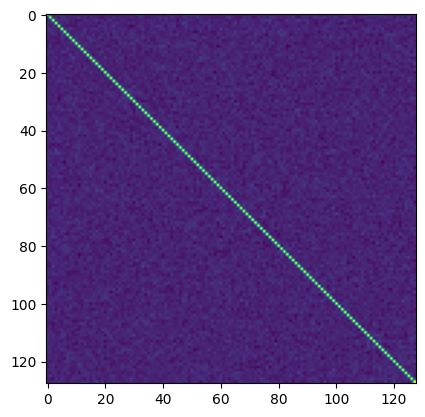

In [11]:
N, K = 1000, 128
np.random.seed(0)
X_rand = np.random.randn(K, N)  # unit normal sample N number of K-vectors
C_rand = np.corrcoef(X_rand)
plt.imshow(C_rand);

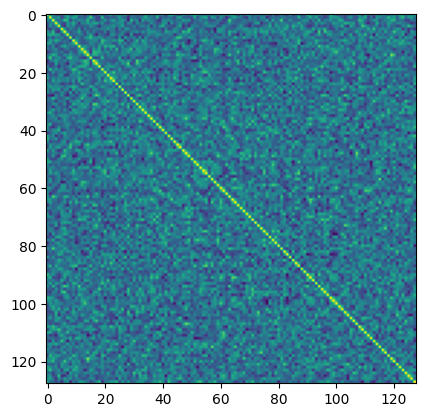

In [12]:
N, K = 20, 128
np.random.seed(0)
X_rand = np.random.randn(K, N)
C_rand = np.corrcoef(X_rand)
plt.imshow(C_rand);

<font color="green"> Write your explanation below.

<font color="red"> Note that $N$ is the number of samples for $K$ random variables. With a small $N$ the randomness in sampling a small collection of points, leads, by happenstance, to some of them being correlated to each other. For a large $N$, any spurious correlations gradually disapear, because the probability of a strong positive or negative correlation in the sample becomes more and more unlikely as $N$ grows.

### Mean and SD <font color="purple"> - 5 points

Calculate, mathematically, the mean and standard deviation of the correlation coefficient between two independent Gaussian random variables with mean 0 and variance 1 over $N$ time points. Does your result agree with the intuition you gathered from the first exercise?

<font color="green"><b> Answer

<font color="green"> Write math calculation below

<font color="red"> 
    
2 points - Mean calculation
    
2 points - Standard Deviation calculation

<font color="green"> Type explanation below.

<font color="red"> 1 points - Explanation. Any explanation will suffice.

<font color="green"><b> Answer

<font color="red">

Let us assume that we have two independent random variables $X$ and $Y$, sampled at $N$ time points to yield series $[X_i]$ and $[Y_i]$. We specified a distribution in the problem for concreteness, but calculating the correlation requires normalizing both samples anyway, resulting in new variables $\tilde X$ and $\tilde Y$ with the same fixed sample mean of zero and sample variance of 1. The correlation coefficient $C$ is now calculated as the sum $C = \tfrac1N \sum_{i=1}^N \tilde X_i \tilde Y_i$.

The expected value of these sums is easy to calculate as follows, using two basic properties of the expectation (its linearity, and the fact that it distributes over products of independent variables):
$$
\mathbb E[C] = \mathbb E \left[\tfrac1N \sum_{i=1}^N \tilde X_i \tilde Y_i \right]
 = \tfrac1N \sum_{i=1}^N \mathbb E [ \tilde X_i \tilde Y_i ]
 = \tfrac1N \sum_{i=1}^N \mathbb E[\tilde X_i] E[\tilde Y_i]
 = 0
$$

The standard deviation of a random variable such as $C$ is the square root of its variance, which in turn can be calculated as $\operatorname{var} C = \mathbb E[C^2] - \mathbb E[C]^2$. In this case, since $\mathbb E[C] = 0$, this simplifies to $\operatorname{var} C = \mathbb E[C^2]$. We can directly plug in the same expressions again to calculate the variance.
$$
\mathbb E[C^2] = \mathbb E \left[ \tfrac{1}{N^2} \sum_{i=1}^N \sum_{j=1}^N \tilde X_i \tilde Y_i \tilde X_j \tilde Y_j \right]
$$

Note that the same independence properties mean that any term where $i \not= j$ will vanish, as it will include a product $X_i X_j$ whose expectation is zero, so the sum simplifies to
$$
\mathbb E[C^2] = \mathbb E \left[ \tfrac{1}{N^2} \sum_{i=1}^N \tilde X_i^2 \tilde Y_i^2 \right]
  = \tfrac{1}{N^2} \sum_{i=1}^N \operatorname{var} X_i \operatorname{var} Y_i
  = \tfrac{1}{N^2} \sum_{i=1}^N 1
  = \tfrac{N}{N^2} = \tfrac1N
  $$
  
Thus the standard deviation of the correlation coefficient between two independent random variables over $N$ samples should be $1 / \sqrt N$.

### Data Manipulation <font color="red">- 1 points

Write some code that generates an array of all the off-diagonal elements of $C_\text{rand}$. (You can write straightforward Python loops for this, but alternately, in numpy, you can use boolean indexing on a 2D array to get a flat output, for example `X[np.eye(K, N, dtype=bool)]` gives you a 1D array of all the elements on the diagonal in the input data.)

<font color="green"><b> Answer

In [21]:
C_off_diagonal = C_rand[ ~np.eye(K, K, dtype=bool) ] 

In [22]:
len( C_off_diagonal  )

16256

In [23]:
sum(C_off_diagonal)

-14.212435179042622

<font color="red"> Give full points if they provide just the upper or lower triangular matrix of datapoints, instead of both sides. It's not what we asked for, but it's what we meant to ask for. You'll know they did this if `len(C_off_diagonal)` is half of what it should be.

### Empirical Mean and SD <font color="red"> - 2 points

Calculate the sample mean and standard deviation of the off-diagonal elements of $C$. How close are they to your predictions? 

<font color="green"><b> Answer

<font color="red">
1 point - Mean adn SD calculation
    
1 point - Explanation

<font color="green"> Write code below

In [70]:
sample_mean = np.mean( C_off_diagonal )
sample_std = np.std( C_off_diagonal )
print(f'With {N=}, {sample_mean=} and {sample_std=}')

With N=100000, sample_mean=-4.5779078982465015e-05 and sample_std=0.003180191695891052


<font color="green"> Write explanation below

<font color="red">Depending the value of $N$ the answers should be reasonably close the the mathematical formulation. Minor extra credit if they rerun it with different values of $N$

## Non-noise Correlations <font color="red"> - 6 points

Consider the correlation matrix shown in **section 1.3**:

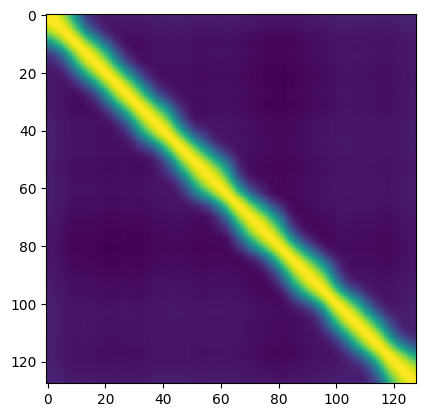

In [24]:
N, K = 250, 128
k = 10
sigma = 5

np.random.seed(0)
points = np.arange(K)
centers = np.random.rand(N) * K
X_blob = scipy.stats.norm(
    scale=sigma, loc=centers
).pdf(points[:,np.newaxis])

mask = np.abs(np.subtract.outer(points, centers)) < k
X_blob *= mask
C_blob = np.corrcoef(X_blob)
plt.imshow(C_blob);

### Changing $N$ <font color="red"> - 2 points

This time, how does the correlation matrix change with different orders of magnitude for $N$?

<font color="green"><b> Answer

<font color="red">
1 point - plots
    
1 point - explanation

<font color="green">Write code for creating plots with different values of $N$ below

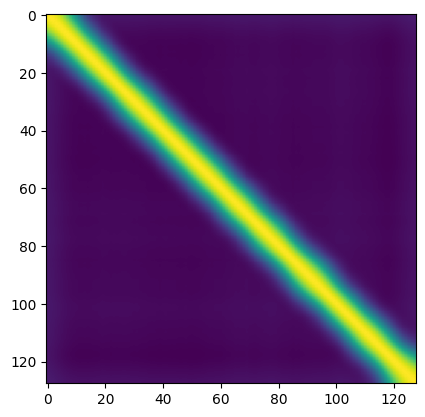

In [74]:
N, K = 1000, 128
k = 10
sigma = 5

np.random.seed(0)
points = np.arange(K)
centers = np.random.rand(N) * K
X_blob = scipy.stats.norm(
    scale=sigma, loc=centers
).pdf(points[:,np.newaxis])

mask = np.abs(np.subtract.outer(points, centers)) < k
X_blob *= mask
C_blob = np.corrcoef(X_blob)
plt.imshow(C_blob);

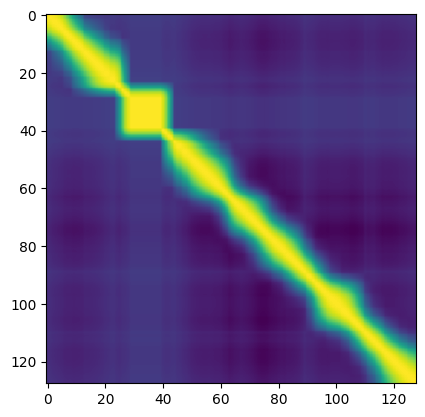

In [75]:
N, K = 40, 128
k = 10
sigma = 5

np.random.seed(0)
points = np.arange(K)
centers = np.random.rand(N) * K
X_blob = scipy.stats.norm(
    scale=sigma, loc=centers
).pdf(points[:,np.newaxis])

mask = np.abs(np.subtract.outer(points, centers)) < k
X_blob *= mask
C_blob = np.corrcoef(X_blob)
plt.imshow(C_blob);

/opt/conda/lib/python3.10/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/conda/lib/python3.10/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


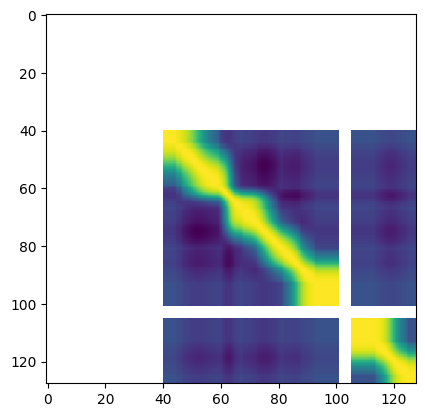

In [76]:
N, K = 10, 128
k = 10
sigma = 5

np.random.seed(0)
points = np.arange(K)
centers = np.random.rand(N) * K
X_blob = scipy.stats.norm(
    scale=sigma, loc=centers
).pdf(points[:,np.newaxis])

mask = np.abs(np.subtract.outer(points, centers)) < k
X_blob *= mask
C_blob = np.corrcoef(X_blob)
plt.imshow(C_blob);

<font color="green"> Write your explanation below.

<font color="red"> Any reasonable explanation describing the plots is sufficient. They will get full points if they either point out the thing with white bars (assuming they make N low enough), or, if they didn't bring N down low enough to see white bars, then just the description of differences between the two plots is sufficient.

### Small $N$ <font color="red">- 3  points

In particular, if you choose a very small value such as $N = 10$, you will see that some rows and columns of the correlation matrix display as white bars in the image, and if you inspect the matrix itself, the value in these locations is `nan`. This is short for “not a number”, and means that the code tried to evaluate an uninterpretable expression like $0 / 0$. Which part of the calculation is failing and why? (Hint: it is related to $k$.)

<font color="green"><b> Answer

<font color="red">     
1 point - the plot

2 points - the explanation. <small>(1 points for general stuff, 1 point explaining zeros in correlation calculation)

<font color="green">Write code for creating the plot

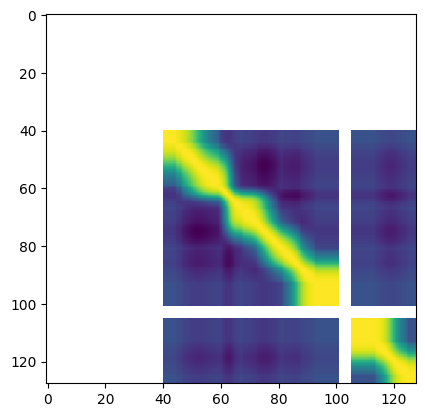

In [77]:
N, K = 10, 128
k = 10
sigma = 5

np.random.seed(0)
points = np.arange(K)
centers = np.random.rand(N) * K
X_blob = scipy.stats.norm(
    scale=sigma, loc=centers
).pdf(points[:,np.newaxis])

mask = np.abs(np.subtract.outer(points, centers)) < k
X_blob *= mask
C_blob = np.corrcoef(X_blob)
plt.imshow(C_blob);

<font color="green"> Write your explanation below.

<font color="red"> 
Note that the calculation for the peason correlation is as follows
    
$$\rho_{X,Y}=\dfrac{\mathbb{E}\begin{bmatrix}(X-\mu_{X})(Y-\mu_{Y})\end{bmatrix}}{\sigma_{X}\sigma_{Y}}$$

Where $\sigma$ and $\mu$ are the means and standard deviation of the random variables $X$ and $Y$. If a row of our matrix $X_\text{blob}$ is all zeros then both it's mean and standard deviation are 0. This makes the top and bottom of the calculation for the pearson correlation zero as well. In math $\frac{0}{0}$ is undefined.

### Changing Blob Size <font color="red">- 1 point

How does the correlation matrix change if you increase $k$ and $\sigma$ together? With $N$ back to its original value, try doubling $k$ and $\sigma$. Why does what you see occur?

<font color="red">
0.5 points plot
    
0.5 points explanation

<font color="green"><b> Answer

<font color="green">Write code for creating the plot

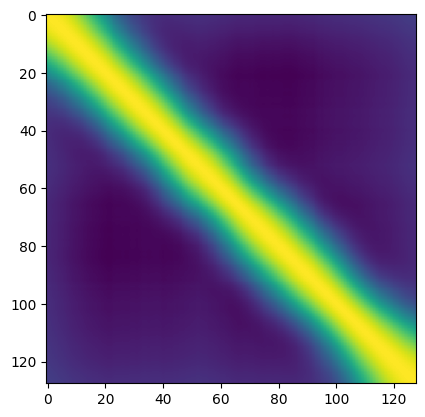

In [79]:
N, K = 250, 128
k = 10*2        # the range of the cuttoff, for which evrerthing outside is 0
sigma = 5*2

np.random.seed(0)
points = np.arange(K)
centers = np.random.rand(N) * K
X_blob = scipy.stats.norm(
    scale=sigma, loc=centers
).pdf(points[:,np.newaxis])

mask = np.abs(np.subtract.outer(points, centers)) < k
X_blob *= mask
C_blob = np.corrcoef(X_blob)
plt.imshow(C_blob);

<font color="green"> Write your explanation below.

<font color="red">It becomes wider and fuzzier. Lol, it been teddy-bear-afied!

## Eigenvalue Spectrum <font color="red"> - 5 points

Consider the eigenvalues and eigenvectors from **section 2.1**:

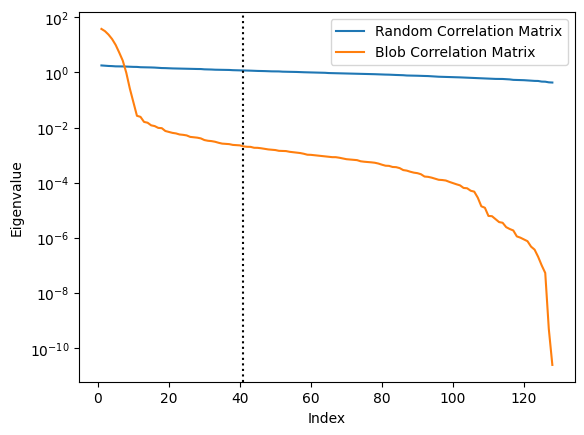

In [80]:
W_rand, U_rand = eigenvalues_eigenvectors(C_rand)  # noise correlation matrix from above
W_blob, U_blob = eigenvalues_eigenvectors(C_blob)  # non-noise correlation matrix from above 

index = 1 + np.arange(K)
plt.semilogy(index, W_rand, label='Random Correlation Matrix')
plt.plot(index, W_blob, label='Blob Correlation Matrix')
plt.xlabel('Index')
plt.ylabel('Eigenvalue')
plt.axvline(2*k+1, ls=':', c='k')
plt.legend();

### Calculate Eigenvalues <font color="red"> - 3 points

Calculate the sum of the eigenvalues for both `C_rand` and `C_blob`. What do you immediately notice about those values? Why does this happen? (Hint: consider the <a href=https://en.wikipedia.org/wiki/Trace_(linear_algebra)>trace</a> of the correlation matrix.)

<font color="green"><b> Answer

<font color="red">
    
1 point - doing calculation
    
1 point - noticing it's equal to $K$
    
1 point - trace of correlation is equal to sum of eigenvalues

<font color="green"> Write your code below.

In [81]:
print(sum(W_rand))
print(sum(W_blob))

127.99999999999997
128.0


<font color="green"> Write your explanation below.

<font color="red"> The trace of the diagonal is equal the the sum of the eignenvalues. The diagonal of any correlation matrix, including $C_\text{rand}$ and $C_\text{blob}$, is 1 for all values. Thus the sum of the diagonal, is $K$. 

### Eigenvalue Analysis <font color="red"> - 2 points

The magnitude of an eigenvalue is, loosely speaking, the importance of the corresponding eigenvector. So, the more the sum is concentrated in the first few eigenvalues, the lower the dimensionality is.

1. Compute the sum of the first $2k$ eigenvalues for both `C_rand` and `C_blob`.
2. Between the 2, compare how many eigenvalues it takes to reach $90\%$ of the full sum for both correlation matrices.

<font color="red"> 0.5 points for each of the 4 calculations

<font color="green"><b> Answer

<font color="green"> Write your code below. It should output answers to the questions above.

In [25]:
print( "Summing 2k eigenvalues for C_Rand:", sum( W_rand[:2*k] ))
print( "Summing 2k eigenvalues for C_Blob:", sum( W_blob[:2*k] ))
print( "How many eigenvalues to reach 90% of K for C_Rand: ", np.where( np.cumsum(W_rand) >= K*.9 )[0][0] )
print( "How many eigenvalues to reach 90% of K for C_Blob: ", np.where( np.cumsum(W_blob) >= K*.9 )[0][0] )

Summing 2k eigenvalues for C_Rand: 44.88056551198343
Summing 2k eigenvalues for C_Blob: 127.7655740752
How many eigenvalues to reach 90% of K for C_Rand:  84
How many eigenvalues to reach 90% of K for C_Blob:  9


## Eigen Vector Basis <font color="red"> - 8 points

Consider the diagrams in **Section 2.2**:

### Low Rank Approximations <font color="red"> - 3 points 

Clearly the first few eigenvectors of `C_blob` are significantly more meaningful in some sense than those of `C_rand`. Let's try to explicitly quantify this! Complete the function `reconstruct(W, U, rank)` below to generate a low-rank approximation using the first `rank` eigenvalues and eigenvectors from the given `W` and `U`, so that the below cell will generate a plot of the relative reconstruction error as a function of the rank of the reconstruction.

<font color="red"> 
2 points - correct code for reconscruction.
    
1 points - description

<font color="green"><b> Answer

<font color="green"> Write your code for the function `reconstruct` below

In [24]:
def reconstruct(W, U, rank):
    W_mini =W[:rank]
    U_mini =U[:,:rank]
    return U_mini @ np.diag(W_mini) @ U_mini.T

Execute the cell below to see a plot. What trend do you see as the rank is varied? Why?

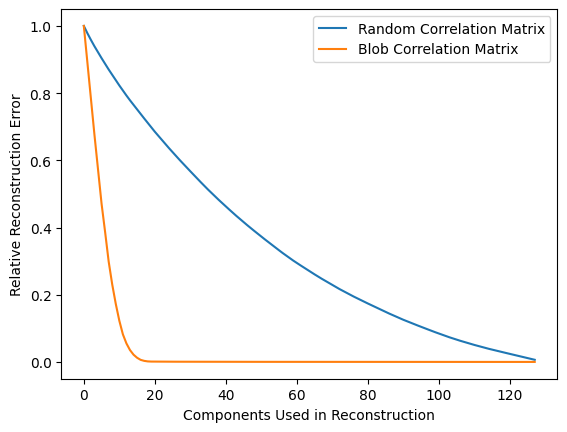

In [25]:
def reconstruction_errors(A, ranks):
    norm = np.linalg.norm(A)
    W, U = eigenvalues_eigenvectors(A)
    return np.array([
            np.linalg.norm( reconstruct(W, U, rank) - A) / norm
            for rank in ranks])

errs_rand = reconstruction_errors(C_rand, range(128))
errs_blob = reconstruction_errors(C_blob, range(128))

plt.figure()
plt.plot(errs_rand, label='Random Correlation Matrix')
plt.plot(errs_blob, label='Blob Correlation Matrix')
plt.xlabel('Components Used in Reconstruction')
plt.ylabel('Relative Reconstruction Error')
plt.legend();

<font color="green"> Describe the resulting plot:

<font color="red"> The plots show how accurate our reconstruciton is of the correlationm matrix give a certain number of eigenvectors. We see that has you use more eigen vectors the reconstruction error goes down. The errors decreases considerably faster for the blob correlation matrix, because there is an underlying correlation pattern that is clearly expressed by the first few eigenvectors.

### Toeplitz Matrices <font color="red"> - 3 points

<font color="red">
    
3 points - correct code
    
give 2 points - if code is wrong but at least in correct direction or required effort
    
give 1 points - if wrote any code

Going back to the form of the eigenvectors themselves, they actually look a lot like the sinusoids which would be the components of a Fourier series. That's actually coming from the matrix being almost <a href=https://en.wikipedia.org/wiki/Toeplitz_matrix>Toeplitz</a>. It's a general property of Toeplitz matrices that their eigenvectors are Fourier components, because matrices with this form represent linear, time-invariant transformations. Let's see how it changes things to fulfill this property exactly instead of approximately. 

Create a new matrix $C_\text{Toeplitz}$ by setting each of the off-diagonals to the mean of the corresponding diagonal in $C_\text{blob}$. To illustrate:

    if:
    
$$
C_{\text{blob}}=\begin{bmatrix}\begin{array}{cccc}
1 & .51 & .28 & .1\\
.51 & 1 & .5 & .32\\
.28 & .5 & 1 & .49\\
.1 & .32 & .49 & 1
\end{array}\end{bmatrix}
$$

<p>&nbsp

    then:
    
$$
C_{\text{Toeplitz}}=\begin{bmatrix}\begin{array}{cccc}
1 & .5 & .3 & .1\\
.5 & 1 & .5 & .3\\
.3 & .5 & 1 & .5\\
.1 & .3 & .5 & 1
\end{array}\end{bmatrix}
$$

<font color="orange"><b>Hint:</b> `numpy.diag` has a function for returning the offset diagonal of a matrix. Examples: `np.diag(X,1)`, `np.diag(X,2)`, ...


<font color="green"><b> Answer

<font color="green"> Write your code to contstruct the Toeplitz matrix

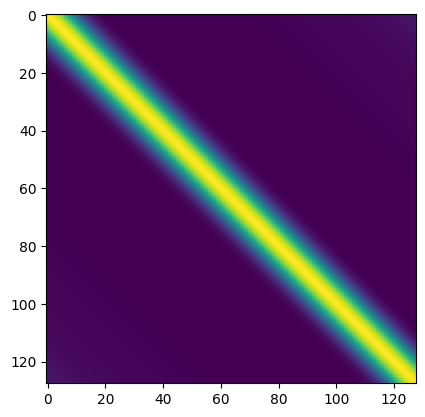

In [34]:
C_toeplitz = scipy.linalg.toeplitz([np.diag(C_blob, i).mean() for i in range(0,K)])

plt.imshow(C_toeplitz);

### Toeplitz Eigenvectors <font color="red"> - 2 points

<font color="red">
1 point - plots
    
1 point - description

Compute the eigenvectors of $C_\text{Toeplitz}$ and plot them both ways, as shown in **section 2.2**. How does this plot compare to the eigenvectors of $C_\text{blob}$?

<font color="green"><b> Answer

<font color="green"> Write your code to compute the eigenvectors

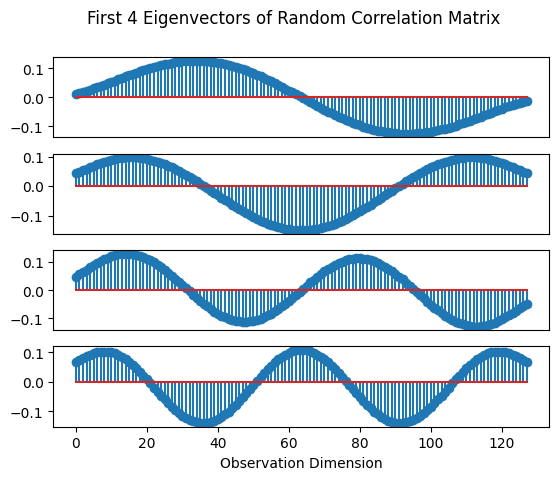

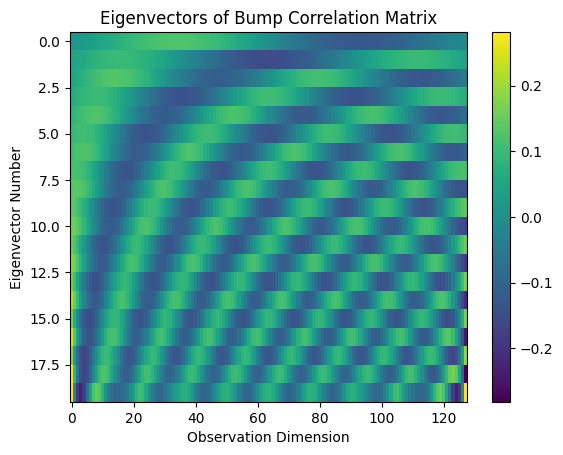

In [35]:
W_toeplitz, U_toeplitz = eigenvalues_eigenvectors(C_toeplitz)

plt.figure()
for i in range(4):
    if i: plt.xticks([])
    plt.subplot(4, 1, i+1)
    plt.stem(U_toeplitz[:,i])
plt.xlabel('Observation Dimension')
plt.suptitle('First 4 Eigenvectors of Random Correlation Matrix');


plt.figure(); plt.imshow(U_toeplitz[:,:2*k].T, interpolation='none')
plt.gca().set_aspect('auto')
plt.ylabel('Eigenvector Number')
plt.xlabel('Observation Dimension')
plt.title('Eigenvectors of Bump Correlation Matrix')
plt.colorbar();

<font color="green">Compare plots

<red color="red"> The plots look like a smoother (aka: cleaner) version of the plots for $C_\text{blob}$